<a href="https://colab.research.google.com/github/yoonji811/ECGProject/blob/master/ECG_Age_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Gender Predict From Standard 12-Lead ECGs
##### 산학프로젝트 with 세종병원
---
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## **1. Diagnostics & ECG Data**
---

In [0]:
diag = pd.read_excel("data/Diagnostics.xlsx")
diag.tail()

,FileName,Rhythm,Beat,PatientAge,DateofBirth,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
10641,MUSE_20181222_204306_99000,SVT,NONE,80,06-03-1937,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,MUSE_20181222_204309_22000,SVT,NONE,81,10-21-1936,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10643,MUSE_20181222_204310_31000,SVT,NONE,39,10-28-1978,MALE,152,92,152,340,540,250,38,25,208,284,378
10644,MUSE_20181222_204312_58000,SVT,NONE,76,07-18-1941,MALE,175,178,128,310,529,98,-83,29,205,269,360
10645,MUSE_20181222_204314_78000,SVT,NONE,75,10-22-1943,MALE,117,104,140,312,435,263,144,19,208,278,364


In [0]:
male = diag[diag.Gender=='MALE'].sample(2500, random_state=42)
female = diag[diag.Gender=='FEMALE'].sample(2500, random_state=42)

In [0]:
diag5_balanced = pd.concat([male,female],axis=0).sort_index()
diag5_balanced.tail()

,FileName,Rhythm,Beat,PatientAge,DateofBirth,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
10638,MUSE_20181222_204249_88000,SVT,NONE,69,04-21-1948,MALE,178,170,122,308,530,57,225,29,203,264,357
10639,MUSE_20181222_204302_49000,SVT,NONE,36,03-06-1981,MALE,220,220,110,224,428,-77,79,36,212,267,324
10641,MUSE_20181222_204306_99000,SVT,NONE,80,06-03-1937,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,MUSE_20181222_204309_22000,SVT,NONE,81,10-21-1936,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10645,MUSE_20181222_204314_78000,SVT,NONE,75,10-22-1943,MALE,117,104,140,312,435,263,144,19,208,278,364


In [0]:
diag5_balanced.Gender.value_counts()

MALE      2500
FEMALE    2500
Name: Gender, dtype: int64

In [27]:
diag5_balanced.PatientAge.describe()

count    5000.000000
mean       58.906600
std        18.036456
min         4.000000
25%        49.000000
50%        61.000000
75%        71.000000
max        98.000000
Name: PatientAge, dtype: float64

In [0]:
#diag5_balanced.to_excel("data/Diagnostics_balanced5000.xlsx")
diag5_balanced = pd.read_excel("/content/drive/My Drive/Colab Notebooks/세종병원/Diagnostics_balanced5000.xlsx",index_col=0)

## **2. Make 4D Array for CNN**
---

In [0]:
from tqdm.notebook import tqdm

ECG5_bal = []
for fName in tqdm(diag5_bal.FileName):
    df = pd.read_csv(f"data/ECGData/{fName}.csv")
    df = df.to_numpy()
    df = np.transpose(df)
    ECG5_bal.append(df)

ECG5_bal = np.array(ECG5_bal)

In [0]:
ECG = np.reshape(ECG5_bal,(len(diag5_bal),12,5000,1))

In [0]:
#np.save("ECG5_bal_reshape.npy", ECG)
ECG = np.load("/content/drive/My Drive/Colab Notebooks/세종병원/ECG5_bal_reshape.npy")

In [4]:
print(ECG.shape)

(5000, 12, 5000, 1)


## **3. Data Split**
---

In [5]:
label_age = diag5_balanced.PatientAge
label_age.tail()

10638    69
10639    36
10641    80
10642    81
10645    75
Name: PatientAge, dtype: int64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(ECG, label_age, test_size=0.36, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=42)

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2400, 12, 5000, 1)
(800, 12, 5000, 1)
(1800, 12, 5000, 1)
(2400,)
(800,)
(1800,)


## **4. Build Model & Train**
---

- **Temporal Analysis**

In [0]:
model = Sequential()

model.add(ZeroPadding2D(padding=(0,2560), input_shape=(12,5000,1)))

model.add(Conv2D(filters=16,
                kernel_size=(1,7)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,2)))

model.add(Conv2D(filters=16,
                kernel_size=(1,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,4)))

model.add(Conv2D(filters=32,
                kernel_size=(1,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,2)))

model.add(Conv2D(filters=32,
                kernel_size=(1,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,4)))

model.add(Conv2D(filters=64,
                kernel_size=(1,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,2)))

model.add(Conv2D(filters=64,
                kernel_size=(1,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,2)))

model.add(Conv2D(filters=64,
                kernel_size=(1,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,2)))

model.add(Conv2D(filters=64,
                kernel_size=(1,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

- **Spatial Analysis**

In [0]:
model.add(Conv2D(filters=128,
                kernel_size=(12,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,2)))

- **Flattening + DNN**

In [0]:
model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5)) 

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5)) 

model.add(Dense(1, activation='linear'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 12, 10120, 1)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 12, 10114, 16)     128       
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 10114, 16)     64        
_________________________________________________________________
activation (Activation)      (None, 12, 10114, 16)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 5057, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 5053, 16)      1296      
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 5053, 16)      6

In [0]:
adam = Adam(learning_rate = 0.003)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae','mse'])

In [13]:
early_stop = EarlyStopping(patience = 30)
check_point = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/세종병원/best_age.h5', save_best_only=True)

epochs = 200
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stop, check_point], validation_data=(X_val, y_val)) 

Epoch 1/200
38/38 [==============================] - 17s 435ms/step - loss: 3481.1243 - mae: 56.3723 - mse: 3485.2197 - val_loss: 3749.8867 - val_mae: 59.0534 - val_mse: 3742.9763
Epoch 2/200
38/38 [==============================] - 15s 394ms/step - loss: 2908.7207 - mae: 51.5135 - mse: 2912.2866 - val_loss: 3153.9517 - val_mae: 53.7328 - val_mse: 3147.7883
Epoch 3/200
38/38 [==============================] - 15s 394ms/step - loss: 2213.6328 - mae: 44.2704 - mse: 2211.3477 - val_loss: 1547.6923 - val_mae: 36.2727 - val_mse: 1546.0593
Epoch 4/200
38/38 [==============================] - 15s 399ms/step - loss: 1532.9353 - mae: 35.6434 - mse: 1532.4253 - val_loss: 719.0039 - val_mae: 21.3344 - val_mse: 720.0711
Epoch 5/200
38/38 [==============================] - 14s 380ms/step - loss: 937.1309 - mae: 26.3087 - mse: 936.3854 - val_loss: 809.6193 - val_mae: 24.2097 - val_mse: 811.2194
Epoch 6/200
38/38 [==============================] - 15s 399ms/step - loss: 548.7440 - mae: 19.3285 - mse:

## **5. Evaluate Model & Visualization**
---

In [14]:
train_score = model.evaluate(X_train,y_train)
val_score = model.evaluate(X_val,y_val)

print('Train Score:',train_score)
print('Test Score:',val_score)

25/25 [==============================] - 1s 54ms/step - loss: 297.5904 - mae: 13.7981 - mse: 297.5904
Train Score: [162.69100952148438, 10.660910606384277, 162.69100952148438]
Test Score: [297.5904235839844, 13.798091888427734, 297.5904235839844]


In [15]:
print('Average Train MAE:', np.mean(history.history['mae']))
print('Average val MAE:', np.mean(history.history['val_mae']))

Average Train MAE: 12.646269590426714
Average val MAE: 13.115102608998617


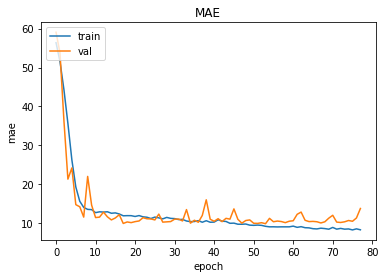

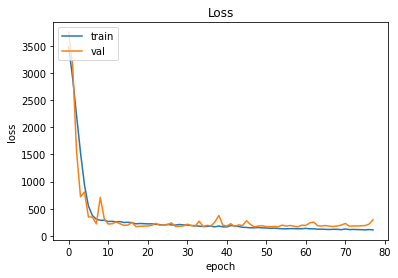

In [16]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

## **6. ROC Curve**
---
### 6-1. Validation Set

In [0]:
val_pred = model.predict(X_val)

In [25]:
val_pred

array([[ 1.9463449 ],
       [33.994583  ],
       [14.883433  ],
       [ 2.6379848 ],
       [32.097584  ],
       [26.357384  ],
       [ 2.804825  ],
       [24.601183  ],
       [ 2.1871555 ],
       [ 1.3209159 ],
       [26.542965  ],
       [ 4.7351704 ],
       [40.221573  ],
       [38.360836  ],
       [ 3.1911142 ],
       [39.375492  ],
       [37.239037  ],
       [ 2.5959404 ],
       [ 2.109325  ],
       [ 2.617705  ],
       [ 4.224766  ],
       [32.9666    ],
       [ 4.7517524 ],
       [15.071225  ],
       [32.001072  ],
       [ 2.524593  ],
       [ 8.960067  ],
       [31.655563  ],
       [24.939371  ],
       [ 3.5700731 ],
       [32.21887   ],
       [ 1.9647849 ],
       [40.78185   ],
       [39.754616  ],
       [ 3.0106668 ],
       [26.681864  ],
       [ 5.7304816 ],
       [19.290867  ],
       [42.89328   ],
       [42.190784  ],
       [ 3.3406377 ],
       [46.827522  ],
       [42.552753  ],
       [50.620132  ],
       [ 3.164588  ],
       [ 3

In [0]:
val_pred_prob = np.max(val_pred, axis=-1)
val_pred_cat = np.argmax(val_pred, axis=-1)

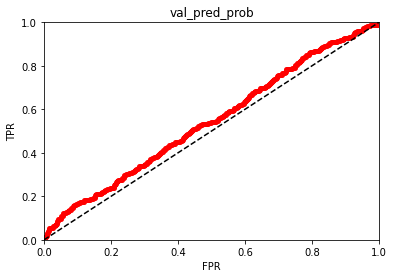

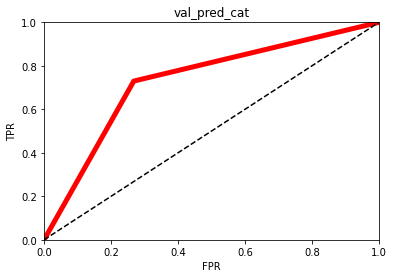

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr,tpr,'r-',linewidth=5, label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.axis([0,1,0,1])
  plt.xlabel("FPR")
  plt.ylabel("TPR")

fpr, tpr, _  = roc_curve(y_val[:,1],val_pred_prob)
plot_roc_curve(fpr,tpr)
plt.title('val_pred_prob')
plt.show()

fpr, tpr, _  = roc_curve(y_val[:,1],val_pred_cat)
plot_roc_curve(fpr,tpr)
plt.title('val_pred_cat')
plt.show()

In [0]:
print('AUC of val_pred_prob =', roc_auc_score(y_val[:,1], val_pred_prob))
print('AUC of val_pred_cat =', roc_auc_score(y_val[:,1], val_pred_cat))

AUC of val_pred_prob = 0.54452
AUC of val_pred_cat = 0.731


### 6-2. Test Set

In [0]:
y_pred = model.predict(X_test)

In [0]:
test_pred_prob = np.max(y_pred,axis=-1)
test_pred_cat = np.argmax(y_pred, axis=-1)

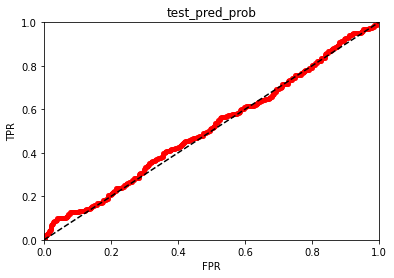

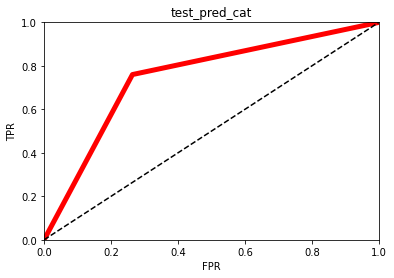

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr,tpr,'r-',linewidth=5, label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.axis([0,1,0,1])
  plt.xlabel("FPR")
  plt.ylabel("TPR")

fpr, tpr, _  = roc_curve(y_test[:,1],test_pred_prob)
plot_roc_curve(fpr,tpr)
plt.title('test_pred_prob')
plt.show()

fpr, tpr, _  = roc_curve(y_test[:,1],test_pred_cat)
plot_roc_curve(fpr,tpr)
plt.title('test_pred_cat')
plt.show()

In [0]:
print('AUC of test_pred_prob =', roc_auc_score(y_test[:,1], test_pred_prob))
print('AUC of test_pred_cat =', roc_auc_score(y_test[:,1], test_pred_cat))

AUC of test_pred_prob = 0.5138560000000001
AUC of test_pred_cat = 0.748
